In [1]:
import h5py
import numpy as np
from glob import glob
from tqdm import tqdm
import torch
from sklearn.metrics import balanced_accuracy_score, jaccard_score

In [56]:
addrs = np.sort(glob('voronoi/v2/med_res/points/*.hdf5'))

In [57]:
len(addrs)

891

In [58]:
with h5py.File('/gpfs/gpfs0/3ddl/sharp_features/data_v2_cvpr/points/med_res.json/0.0/train/train_0.hdf5', 'r') as f:
#     d = torch.flatten(torch.from_numpy(f['distances'][:]), start_dim=1).numpy()[:100]
#     p = f['points'][:100]
    d = f['distances'][:100]
# d.shape
thr_d = np.zeros_like(d)
thr_d[d < 0.05] = 1

ba = []
iou = []
for addr in tqdm(addrs):
    with h5py.File(addr, 'r') as f:
        v = f['distances'][:]
    ba_small = []
    iou_small = []
    for i in range(len(v)):
        ba_small.append(balanced_accuracy_score(thr_d[i], v[i]))
        iou_small.append(jaccard_score(thr_d[i], v[i]))
    ba.append(ba_small)
    iou.append(iou_small)

100%|██████████| 891/891 [07:26<00:00,  2.00it/s]


In [59]:
addrs[np.array(ba).mean(-1).argmax()]

'voronoi/v2/med_res/points/0.1_0.2_0.3.hdf5'

In [60]:
np.array(ba)[np.array(iou).mean(-1).argmax()].mean(-1).max()

0.9238490784572491

In [61]:
addrs[np.array(iou).mean(-1).argmax()]

'voronoi/v2/med_res/points/0.05_0.1_0.3.hdf5'

In [62]:
sel = d[:100].sum(-1) < 4096

In [63]:
addrs[np.array(ba)[:,sel].mean(-1).argmax()]

'voronoi/v2/med_res/points/0.6_0.1_0.05.hdf5'

In [64]:
addrs[np.array(iou)[:,sel].mean(-1).argmax()]

'voronoi/v2/med_res/points/0.05_0.1_0.3.hdf5'

In [25]:
np.array(ba).mean(-1).argmax()

211

In [40]:
np.array(ba[94]).mean(-1)

0.8972608553034918

In [54]:
np.array(ba)[94][1]

0.9166250624063904

In [55]:
with h5py.File(addrs[94], 'r') as f:
    v = f['distances'][:]

In [57]:
v[1].sum()

758.0

In [28]:
np.array(iou).mean(-1).max()

0.16034254761284913

In [78]:
(np.array(ba)[244,sel] - np.array(ba)[94,sel]).argmin()

27

In [79]:
np.arange(0,100)[sel][27]

78

In [70]:
addrs[244]

'voronoi/v2/high_res/0.0/points/0.2_0.05_0.1.hdf5'

In [23]:
sel

array([ True, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
        True, False, False, False,  True, False,  True, False, False,
        True,  True, False, False, False,  True, False, False, False,
       False,  True,  True, False,  True, False, False, False,  True,
       False, False,  True,  True, False,  True, False, False, False,
        True, False, False, False,  True,  True, False, False, False,
       False, False, False,  True, False, False,  True, False,  True,
       False, False,  True,  True, False,  True,  True,  True,  True,
       False, False,  True, False, False,  True,  True, False, False,
        True, False, False, False, False, False,  True,  True, False,
        True])

In [24]:
np.array(ba)[94,sel].mean(-1)

0.9490193214716722

In [31]:
np.array(iou)[74,sel]

array([0.02197266, 0.02685547, 0.02246094, 0.02148438, 0.02075195,
       0.04931641, 0.03613281, 0.02905273, 0.05883789, 0.01879883,
       0.02368164, 0.01806641, 0.06054688, 0.11621094, 0.06567383,
       0.05273438, 0.03076172, 0.03344727, 0.28295898, 0.03320312,
       0.02392578, 0.02563477, 0.03466797, 0.03222656, 0.03320312,
       0.05004883, 0.03198242, 0.10473633, 0.02587891, 0.02563477,
       0.04394531, 0.0637207 , 0.0324707 , 0.02197266, 0.0456543 ,
       0.02294922, 0.03564453])

In [12]:
sel.sum()

2275

In [43]:
import k3d
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

In [44]:
def get_colors(pred, cmap):
    hex_colors = []
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cmap = cmap
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    for i in pred:
#         hex_colors.append(m.to_rgba(i))
        hex_colors.append(int(mpl.colors.to_hex(m.to_rgba(i)).replace('#','0x'),16))
    hex_colors = np.array(hex_colors, 'uint32')
    return(hex_colors)

In [45]:
def image_to_points(image, resolution_3d=0.02):
    """
    Depth image to point cloud transformation
        input: image: depth image, shape = (image_height, image_width)
               resolution_3d: sampling resolution, float
 
        output: points: point cloud obtained from the depth image, shape = (image_height * image_width, 3)
    """
    image_height, image_width = image.shape[0], image.shape[1]
    screen_aspect_ratio = image_width / image_height
    rays_screen_coords = np.mgrid[0:image_height, 0:image_width].reshape(
            2, image_height * image_width).T

    rays_origins = (rays_screen_coords / np.array([[image_height, image_width]]))   # [h, w, 2], in [0, 1]
    factor = image_height / 2 * resolution_3d
    rays_origins[:, 0] = (-2 * rays_origins[:, 0] + 1) * factor  # to [-1, 1] + aspect transform
    rays_origins[:, 1] = (-2 * rays_origins[:, 1] + 1) * factor * screen_aspect_ratio
    rays_origins = np.concatenate([
        rays_origins,
        np.zeros_like(rays_origins[:, [0]])
    ], axis=1)
    points = np.zeros((image_height * image_width, 3))
    points[:, 0] = rays_origins[:, 0]
    points[:, 1] = rays_origins[:, 1]
    points[:, 2] = image.ravel()
    return points

In [81]:
with h5py.File(addrs[244], 'r') as f:
    v_244 = f['distances'][:]
    
with h5py.File(addrs[94], 'r') as f:
    v_94 = f['distances'][:]

In [87]:
plot = k3d.plot()
# poi = image_to_points(data[sample])
# sample_better = 80
# sample_worse = 78
ori_1 = [0,1,1]
ori_2 = [2.1,1,1]
ori_3 = [4.2,1,1]
ori_4 = [6.3,1,1]
vec = [0,0,0]

seg_78 = np.zeros_like(d[78])
seg_78[d[78] < 0.02] = 1

seg_80 = np.zeros_like(d[80])
seg_80[d[80] < 0.02] = 1

#     col_tr = get_colors(d[sample], cm.coolwarm_r)
#     col_pr_b = get_colors(pred[sample], cm.coolwarm_r)
col_78 = get_colors(seg_78, cm.coolwarm)
col_80 = get_colors(seg_80, cm.coolwarm)
col_244_78 = get_colors(v_244[78], cm.coolwarm)
col_244_80 = get_colors(v_244[80], cm.coolwarm)
col_94_78 = get_colors(v_94[78], cm.coolwarm)
col_94_80 = get_colors(v_94[80], cm.coolwarm)

#     data_shift = data[sample].copy()
#     data_shift[:,0] = data_shift[:,0]+2.1
#     data_shift_2 = data[sample].copy()
#     data_shift_2[:,0] = data_shift_2[:,0]+4.2
#     data_shift_3 = data[sample].copy()
#     data_shift_3[:,0] = data_shift_3[:,0]+6.3

#     points = k3d.points(data[sample],col_tr, 
#                         point_size=0.05, shader='mesh', )
#     points1 = k3d.points(data[sample],col_pr_b, 
#                         point_size=0.05, shader='mesh', )
points1 = k3d.points(p[78]-p[78].mean(0),col_78, 
                    point_size=0.05, shader='mesh', name='GT')
points2 = k3d.points(p[78]-p[78].mean(0),col_94_78, 
                    point_size=0.05, shader='mesh', name='V, BA={}'.format(np.array(ba)[94,78]))
points3 = k3d.points(p[78]-p[78].mean(0),col_244_78, 
                    point_size=0.05, shader='mesh', name='V, BA={}'.format(np.array(ba)[244,78]))
points4 = k3d.points(p[80]-p[80].mean(0),col_80, 
                    point_size=0.05, shader='mesh', name='GT')
points5 = k3d.points(p[80]-p[80].mean(0),col_94_80, 
                    point_size=0.05, shader='mesh', name='V, BA={}'.format(np.array(ba)[94,80]))
points6 = k3d.points(p[80]-p[80].mean(0),col_244_80, 
                    point_size=0.05, shader='mesh', name='V, BA={}'.format(np.array(ba)[244,80]))
#     vects_t = k3d.vectors(ori_1, vec, use_head=False, labels=['true'])
#     vects_pb = k3d.vectors(ori_2, vec, use_head=False, labels=['DGCNN'])
#     vects_p = k3d.vectors(ori_3, vec, use_head=False, labels=[_type])
#     vects_v = k3d.vectors(ori_4, vec, use_head=False, labels=['voronoi'])

plot += points1+points2+points3+points4+points5+points6

f = open("beter_worse_v.html", 'w')
f.write(plot.get_snapshot())
f.close()

In [16]:
with h5py.File('1.hdf5', 'r') as f:
    print(f['distances'].shape)

(100, 4096)


In [6]:
with h5py.File(addrs[94], 'r') as f:
    v = f['distances'][:]

In [58]:
mode = 'noise_0.02'
# _type = 'DGCNN'
for num,sample in enumerate(np.where(sel)[0][:10]):
    print(num)

    plot = k3d.plot()
#     poi = image_to_points(data[sample])
    poi = p[sample]
    ori_1 = [0,1,1]
    ori_2 = [2.1,1,1]
    ori_3 = [4.2,1,1]
    ori_4 = [6.3,1,1]
    vec = [0,0,0]
    
    seg = np.zeros_like(d[sample])
    seg[d[sample] < 0.02] = 1

#     col_tr = get_colors(d[sample], cm.coolwarm_r)
#     col_pr_b = get_colors(pred[sample], cm.coolwarm_r)
    col_pr = get_colors(seg, cm.coolwarm)
    col_v = get_colors(v[sample], cm.coolwarm)

#     data_shift = data[sample].copy()
#     data_shift[:,0] = data_shift[:,0]+2.1
#     data_shift_2 = data[sample].copy()
#     data_shift_2[:,0] = data_shift_2[:,0]+4.2
#     data_shift_3 = data[sample].copy()
#     data_shift_3[:,0] = data_shift_3[:,0]+6.3

#     points = k3d.points(data[sample],col_tr, 
#                         point_size=0.05, shader='mesh', )
#     points1 = k3d.points(data[sample],col_pr_b, 
#                         point_size=0.05, shader='mesh', )
    points2 = k3d.points(poi,col_pr, 
                        point_size=0.05, shader='mesh', )
    points3 = k3d.points(poi,col_v, 
                        point_size=0.05, shader='mesh', )
#     vects_t = k3d.vectors(ori_1, vec, use_head=False, labels=['true'])
#     vects_pb = k3d.vectors(ori_2, vec, use_head=False, labels=['DGCNN'])
#     vects_p = k3d.vectors(ori_3, vec, use_head=False, labels=[_type])
#     vects_v = k3d.vectors(ori_4, vec, use_head=False, labels=['voronoi'])

    plot += points2+points3

    f = open("%s_%s.html" %(mode,sample), 'w')
    f.write(plot.get_snapshot())
    f.close()

0
1
2
3
4
5
6
7
8
9


In [9]:
with h5py.File('/gpfs/gpfs0/3ddl/sharp_features/data_v2_cvpr/images/high_res.json/0.0/train/train_0.hdf5', 'r') as f:
    data = f['image'][:100]

In [51]:
np.argsort(np.array(ba)[17][sel])

array([1210, 1211, 1720, ..., 1950,  868,  666])

In [58]:
d[sel][1210].sum()

4033.170524040394

In [47]:
np.array(ba)[:,sel].mean(-1)

array([0.51231421, 0.52245165, 0.50584907, 0.51428537, 0.52708684,
       0.5008573 , 0.5065541 , 0.52580163, 0.50029955, 0.52293128,
       0.52438743, 0.51946198, 0.52816047, 0.52875896, 0.50599062,
       0.5188304 , 0.52664983, 0.50014012, 0.52417846, 0.5240779 ,
       0.5241113 , 0.52904019, 0.52864282, 0.52764221, 0.5185989 ,
       0.51920367, 0.50632579])

In [41]:
with h5py.File('/gpfs/gpfs0/3ddl/sharp_features/data_v2_cvpr/points/high_res/0.0/train/train_0.hdf5', 'r') as f:
    print((f['distances'][:].sum(-1) < 4096).sum())

5963


In [125]:
np.where(d.sum(-1) < 4096)[0][15]

95

In [ ]:
8886

In [127]:
data[:100].shape

(100, 64, 64)

In [4]:
noise = '0.0025'

with h5py.File('/gpfs/gpfs0/3ddl/sharp_features/data_v3_cvpr/images/high_res.json/'+noise+'/train/train_0.hdf5', 'r') as f:
#     d = torch.flatten(torch.from_numpy(f['distances'][:]), start_dim=1).numpy()[:100]
    p = f['image'][:100]
#     d = f['distances'][:100]

In [5]:
p[:100].shape

(100, 64, 64)

In [14]:
with h5py.File('v_selection_p.hdf5', 'w') as f:
#     f.create_dataset("image", data=p)
    print(list(f.keys()))

[]


In [46]:
np.load('p.npy')

array([[[  7.73179034,   7.72918328,   7.73398693, ...,   7.73320133,
           7.72959513,   7.7312132 ],
        [  7.71388392,   7.71592402,   7.72064151, ...,   7.71625222,
           7.71882737,   7.71900379],
        [  7.6965498 ,   7.69869577,   7.70328222, ...,   7.69989496,
           7.70426702,   7.69845125],
        ...,
        [  8.41617373,   8.39570567,   8.38015675, ...,   7.31241652,
           7.29213194,   7.2777569 ],
        [  8.44221593,   8.42571688,   8.40887527, ...,   7.33696454,
           7.31566415,   7.29707341],
        [  8.4688408 ,   8.45281013,   8.43699635, ...,   7.36654102,
           7.34497197,   7.32967432]],

       [[ 21.62415142,  21.60249219,  21.58888265, ...,  20.5509217 ,
          20.53372947,  20.5156116 ],
        [ 21.62606465,  21.61042395,  21.59224782, ...,  20.55158449,
          20.53955135,  20.52779164],
        [ 21.63505105,  21.61268247,  21.6027323 , ...,  20.56114026,
          20.54395152,  20.52782804],
        ...,


In [91]:
with h5py.File('/gpfs/gpfs0/3ddl/sharp_features/data_v2_cvpr/images/high_res.json/0.0/train/train_0.hdf5', 'r') as f:
    d = torch.flatten(torch.from_numpy(f['distances'][:]), start_dim=1).numpy()[None, 8886]
# d.shape
thr_d = np.zeros_like(d)
thr_d[d < 0.02] = 1

ba = []
iou = []
for addr in addrs:
    with h5py.File(addr, 'r') as f:
        v = f['distances'][:]
#     ba_small = []
#     iou_small = []
    for i in tqdm(range(len(v))):
        ba.append(balanced_accuracy_score(thr_d[i], v[i]))
        iou.append(jaccard_score(thr_d[i], v[i]))
#     ba.append(ba_small)
#     iou.append(iou_small)

100%|██████████| 1/1 [00:00<00:00, 150.59it/s]


In [68]:
len(addrs)

891

In [104]:
addrs[np.array(ba).argmax()]

'voronoi/v2/high_res/0.0/crap/0.05_0.1_0.3.hdf5.hdf5'

In [100]:
np.array(ba).argmax()

94

In [80]:
data

array([[[ 14.10760198,  14.10971501,  14.11225638, ...,  14.5567128 ,
          14.5699286 ,  14.58393303],
        [ 14.09828231,  14.10047608,  14.1034042 , ...,  14.5466427 ,
          14.5598585 ,  14.57378318],
        [ 14.08896264,  14.0916239 ,  14.09455203, ...,  14.5365726 ,
          14.5497884 ,  14.56363334],
        ...,
        [ 13.85509906,  13.85713494,  13.85917083, ...,  14.2581205 ,
          14.27009008,  14.28285788],
        [ 13.85563463,  13.85767052,  13.8597064 , ...,  14.25842823,
          14.27088176,  14.28364956],
        [ 13.8561702 ,  13.85820609,  13.86024198, ...,  14.25890563,
          14.27167343,  14.28444124]],

       [[ 81.30263688,  81.29103626,  81.27943564, ...,  80.63634057,
          80.62613353,  80.61592649],
        [ 81.31319463,  81.30159401,  81.28999339, ...,  80.64699815,
          80.63679111,  80.62658407],
        [ 81.32375237,  81.31215175,  81.30055113, ...,  80.65765574,
          80.6474487 ,  80.63724166],
        ...,


In [82]:
v.shape

(1, 4096)

In [87]:
ba[5]

1.0

In [88]:
v

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [90]:
thr_d[i].sum()

0.0

In [19]:
with h5py.File('/gpfs/gpfs0/3ddl/sharp_features/data_v2_cvpr/images/high_res.json//0.0/val_with_normals_and_voronoi/train_0.hdf5', 'r') as f:
#     print(list(f.keys()))
    data = f['image'][:]
    label = torch.flatten(torch.from_numpy(f['distances'][:]), start_dim=1).numpy()
#     label = f['distances'][:]
#     n = f['normals'][:]
    v = f['voronoi'][:]
#     n_10 = f['normals_estimation_10'][:]
#     n_100 = f['normals_estimation_100'][:]
#     n_s = f['num_surfaces'][:]
    
with h5py.File('/gpfs/gpfs0/3ddl/sharp_features/data_v2_cvpr/images/high_res.json//0.0/val_with_normals_and_voronoi/train_1.hdf5', 'r') as f:
#     print(list(f.keys()))
    data = np.concatenate([data, f['image'][:]], axis=0)
    label = np.concatenate([label, torch.flatten(torch.from_numpy(f['distances'][:]), start_dim=1).numpy()], axis=0)
#     label = np.concatenate([label, f['distances'][:]], axis=0)
#     n = np.concatenate([n, f['normals'][:]], axis=0)
    v = np.concatenate([v, f['voronoi'][:]], axis=0)
#     n_10 = np.concatenate([n_10, f['normals_estimation_10'][:]], axis=0)
#     n_100 = np.concatenate([n_100, f['normals_estimation_100'][:]], axis=0)
#     n_s = np.concatenate([n_s,f['num_surfaces'][:]], axis=0)

In [51]:
from sklearn.metrics import balanced_accuracy_score, jaccard_score

label_thr = np.zeros_like(label)
label_thr[label < 0.02] = 1

In [20]:
pred = []
for i in tqdm(range(len(v))):
    pred.append(np.load('/gpfs/gpfs0/3ddl/sharp_features/old_experiments/baseline-image/predictions/val_'+str(i)+'.npy'))
#     pred_thr = np.zeros_like(pred)
#     pred_thr[pred < 0.02] = 1
# pred = np.load('pointnet_outputs/v2/dgcnn_4k_hist/val/pred.npy')
# pred.shape

100%|██████████| 32768/32768 [07:08<00:00, 76.39it/s] 


In [5]:
v.shape

NameError: name 'v' is not defined

In [8]:
pred = np.array(pred)

In [10]:
pred.shape

(31796, 4096)

In [12]:
pred_thr = np.zeros_like(pred)
pred_thr[pred < 0.02] = 1

In [13]:
np.sqrt(((pred - label) ** 2).mean(-1)).mean()

0.011675092930046269

In [21]:
sh = np.concatenate([np.load('sharpness/sh_f_10_images_0.npy'), np.load('sharpness/sh_f_10_images_1.npy')], axis=0)

In [22]:
mses = []
for i in tqdm([0.02,0.03, 0.04, 0.05,0.06, 0.07, 0.08, 0.09, 0.1]):
    label_new = label / i
    label_new[label_new > 1] = 1
    mses.append(np.sqrt((((1-sh) - label_new) ** 2).mean(-1)))

100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


In [23]:
np.array(mses).mean(-1).argmin()

4

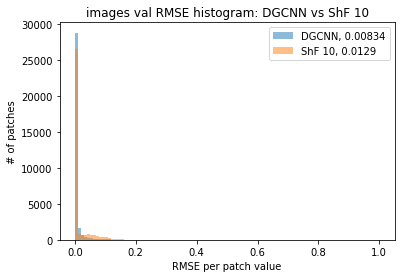

In [25]:
_data = 'images'
_type = 'RMSE'
_type_sh = 'rmse'
net = np.sqrt(((pred - label) ** 2).mean(-1))
vor = mses[4]

plt.hist(net, bins=100, range=(0,1), log=False, 
         label='DGCNN, {:.3}'.format(net.mean()), alpha=0.5)
plt.hist(vor, bins=100, range=(0,1), log=False, 
         label='ShF 10, {:.3}'.format(vor.mean()), alpha=0.5)
# plt.axvline(np.quantile(net, 0.95), color='k', linestyle='dashed', linewidth=1, 
#             label='95% DGCNN, {:.3}'.format(np.quantile(net, 0.95)))
# plt.axvline(np.quantile(vor, 0.95), color='r', linestyle='dashed', linewidth=1,
#             label='95% Voronoi, {:.3}'.format(np.quantile(vor, 0.95)))
plt.legend()
plt.xlabel('{} per patch value'.format(_type))
plt.ylabel('# of patches')
plt.title('{} val {} histogram: DGCNN vs ShF 10'.format(_data,_type))
# plt.savefig('sh_10_i_{}_hist.pdf'.format(_type_sh))
plt.show()

In [9]:
sh.shape

(31796, 4096)

In [70]:
sh_thr = np.zeros_like(sh)
sh_thr[1-sh < 0.6] = 1

In [65]:
# iou_net = []
# # iou_net_r = []
# ba_net = []
# iou_v = []
# # iou_v_r = []
# ba_v = []

# for i in tqdm(range(len(v))):
# #     pred = np.load('/gpfs/gpfs0/3ddl/sharp_features/experiments/baseline-image/predictions/val_'+str(i)+'.npy')
# #     pred_thr = np.zeros_like(pred)
# #     pred_thr[pred < 0.02] = 1
#     iou_net.append(jaccard_score(label_thr[i], pred_thr[i]))
# #     iou_net_r.append(jaccard_score(1-label_thr[i], 1-pred_thr[i]))
#     ba_net.append(balanced_accuracy_score(label_thr[i], pred_thr[i]))
    
#     iou_v.append(jaccard_score(label_thr[i], v[i]))
# #     iou_v_r.append(jaccard_score(1-label_thr[i], 1-v[i]))
#     ba_v.append(balanced_accuracy_score(label_thr[i], v[i]))

100%|██████████| 32768/32768 [05:08<00:00, 106.23it/s]


In [55]:
iou_net = []
# iou_net_r = []
ba_net = []
iou_sh = []
# iou_v_r = []
ba_sh = []

for i in tqdm(range(len(sh))):
    iou_sh_small = []
    ba_sh_small = []
    pred = np.load('/gpfs/gpfs0/3ddl/sharp_features/old_experiments/baseline-image/predictions/val_'+str(i)+'.npy')
    pred_thr = np.zeros_like(pred)
    pred_thr[pred < 0.02] = 1
    iou_net.append(jaccard_score(label_thr[i], pred_thr))
#     iou_net_r.append(jaccard_score(1-label_thr[i], 1-pred_thr[i]))
    ba_net.append(balanced_accuracy_score(label_thr[i], pred_thr))
    
    for j in [0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        sh_thr = np.zeros_like(sh[i])
        sh_thr[1-sh[i] < j] = 1
        iou_sh_small.append(jaccard_score(label_thr[i], sh_thr))
    #     iou_v_r.append(jaccard_score(1-label_thr[i], 1-v[i]))
        ba_sh_small.append(balanced_accuracy_score(label_thr[i], sh_thr))
    iou_sh.append(iou_sh_small)
    ba_sh.append(ba_sh_small)

  0%|          | 0/32768 [00:00<?, ?it/s]/trinity/home/a.matveev/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/trinity/home/a.matveev/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
100%|██████████| 32768/32768 [50:05<00:00, 10.90it/s]


In [56]:
# ba_v = np.array(ba_v)
# iou_v = np.array(iou_v)
ba_sh = np.array(ba_sh)
iou_sh = np.array(iou_sh)
ba_net = np.array(ba_net)
iou_net = np.array(iou_net)

In [57]:
((iou_sh.mean(0)+ba_sh.mean(0))/2).argmax()

7

In [61]:
iou_sh.mean(0).argmax()

6

In [62]:
iou_sh[sel].mean(0).argmax()

6

In [60]:
ba_sh.mean(0).argmax()

9

In [37]:
ba_sh[sel].mean(0).argmax()

8

In [63]:
import k3d
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

In [64]:
sel = label.sum(-1) < 4096

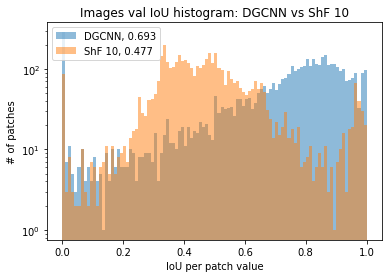

In [67]:
_data = 'Images'
_type = 'IoU'
_type_sh = 'iou_no_flat'
net = iou_net[sel]
vor = iou_sh[sel,7]

plt.hist(net, bins=100, range=(0,1), log=True, 
         label='DGCNN, {:.3}'.format(net.mean()), alpha=0.5)
plt.hist(vor, bins=100, range=(0,1), log=True, 
         label='ShF 10, {:.3}'.format(vor.mean()), alpha=0.5)
# plt.axvline(np.quantile(net, 0.95), color='k', linestyle='dashed', linewidth=1, 
#             label='95% DGCNN, {:.3}'.format(np.quantile(net, 0.95)))
# plt.axvline(np.quantile(vor, 0.95), color='r', linestyle='dashed', linewidth=1,
#             label='95% Voronoi, {:.3}'.format(np.quantile(vor, 0.95)))
plt.legend()
plt.xlabel('{} per patch value'.format(_type))
plt.ylabel('# of patches')
plt.title('{} val {} histogram: DGCNN vs ShF 10'.format(_data,_type))
plt.savefig('sh_10_opt_i_{}_hist.pdf'.format(_type_sh))
plt.show()

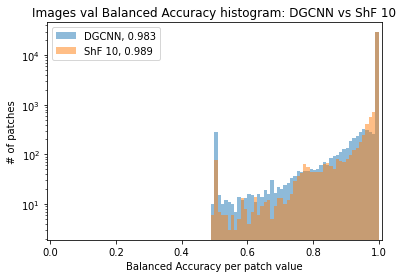

In [69]:
_data = 'Images'
_type = 'Balanced Accuracy'
_type_sh = 'ba'
net = ba_net
vor = ba_sh[:,7]

plt.hist(net, bins=100, range=(0,1), log=True, 
         label='DGCNN, {:.3}'.format(net.mean()), alpha=0.5)
plt.hist(vor, bins=100, range=(0,1), log=True, 
         label='ShF 10, {:.3}'.format(vor.mean()), alpha=0.5)
# plt.axvline(np.quantile(net, 0.95), color='k', linestyle='dashed', linewidth=1, 
#             label='95% DGCNN, {:.3}'.format(np.quantile(net, 0.95)))
# plt.axvline(np.quantile(vor, 0.95), color='r', linestyle='dashed', linewidth=1,
#             label='95% Voronoi, {:.3}'.format(np.quantile(vor, 0.95)))
plt.legend()
plt.xlabel('{} per patch value'.format(_type))
plt.ylabel('# of patches')
plt.xlim(-0.01, 1.01)
plt.title('{} val {} histogram: DGCNN vs ShF 10'.format(_data,_type))
plt.savefig('sh_10_opt_i_{}_hist.pdf'.format(_type_sh))
plt.show()

In [37]:
# _data = 'Images'
# _type = 'IoU'
# _type_sh = 'iou_no_flat'
# net = iou_net[sel]
# vor = iou_v[sel]

# plt.hist(net, bins=100, range=(0,1), log=False, 
#          label='DGCNN, {:.3}'.format(net.mean()), alpha=0.5)
# plt.hist(vor, bins=100, range=(0,1), log=False, 
#          label='Voronoi, {:.3}'.format(vor.mean()), alpha=0.5)
# # plt.axvline(np.quantile(net, 0.95), color='k', linestyle='dashed', linewidth=1, 
# #             label='95% DGCNN, {:.3}'.format(np.quantile(net, 0.95)))
# # plt.axvline(np.quantile(vor, 0.95), color='r', linestyle='dashed', linewidth=1,
# #             label='95% Voronoi, {:.3}'.format(np.quantile(vor, 0.95)))
# plt.legend()
# plt.xlabel('{} per patch value'.format(_type))
# plt.ylabel('# of patches')
# plt.title('{} val {} histogram: DGCNN vs Voronoi'.format(_data,_type))
# # plt.savefig('dgcnn_{}_hist.pdf'.format(_type_sh))
# plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 32768 but corresponding boolean dimension is 31796

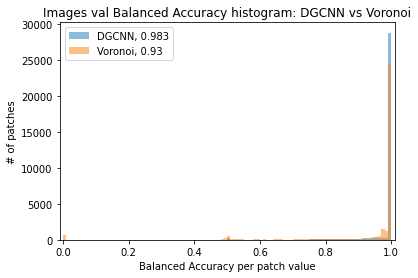

In [70]:
# _data = 'Images'
# _type = 'Balanced Accuracy'
# _type_sh = 'ba'
# net = ba_net
# vor = ba_v

# plt.hist(net, bins=100, range=(0,1), log=False, 
#          label='DGCNN, {:.3}'.format(net.mean()), alpha=0.5)
# plt.hist(vor, bins=100, range=(0,1), log=False, 
#          label='Voronoi, {:.3}'.format(vor.mean()), alpha=0.5)
# # plt.axvline(np.quantile(net, 0.95), color='k', linestyle='dashed', linewidth=1, 
# #             label='95% DGCNN, {:.3}'.format(np.quantile(net, 0.95)))
# # plt.axvline(np.quantile(vor, 0.95), color='r', linestyle='dashed', linewidth=1,
# #             label='95% Voronoi, {:.3}'.format(np.quantile(vor, 0.95)))
# plt.legend()
# plt.xlabel('{} per patch value'.format(_type))
# plt.ylabel('# of patches')
# plt.xlim(-0.01, 1.01)
# plt.title('{} val {} histogram: DGCNN vs Voronoi'.format(_data,_type))
# # plt.savefig('dgcnn_{}_hist.pdf'.format(_type_sh))
# plt.show()

In [34]:
ba_v[sel].shape

(6669,)

In [33]:
sel.sum()

6669

In [26]:
iou_net.shape

(32768,)

In [49]:
np.linalg.norm(poi, axis=1).max()

6.0234612500784195

In [38]:
np.argsort(iou_net[sel])

array([ 500, 1597,  536, ..., 2405, 4520, 4048])

In [57]:
ba_net[sel][3830]

0.4765625

In [78]:
mode = 'worst_sh_10_images'
_type = 'DGCNN'
for num,sample in enumerate(np.where(sel)[0][np.argsort(iou_sh[sel,7])][:10]):
    print(num)

    plot = k3d.plot()
    poi = image_to_points(data[sample])
#     poi = data[sample]
    poi -= poi.mean(0)
    poi /= np.linalg.norm(poi, axis=1).max()

    ori_1 = [0,1,1]
    ori_2 = [2.1,1,1]
    ori_3 = [4.2,1,1]
    ori_4 = [6.3,1,1]
    vec = [0,0,0]
    
    seg = np.zeros_like(label[sample])
    seg[label[sample] < 0.02] = 1

    col_tr_thr = get_colors(label_thr[sample], cm.coolwarm)
    pred = np.load('/gpfs/gpfs0/3ddl/sharp_features/old_experiments/baseline-image/predictions/val_'+str(sample)+'.npy')
    pred_thr = np.zeros_like(pred)
    pred_thr[pred < 0.02] = 1
    col_pr_b_thr = get_colors(pred_thr, cm.coolwarm)
#     col_pr = get_colors(seg, cm.coolwarm)
    col_v_thr = get_colors(sh_thr[sample], cm.coolwarm)
    
    col_tr = get_colors(label[sample], cm.coolwarm_r)
    col_pr_b = get_colors(pred, cm.coolwarm_r)
#     col_pr = get_colors(seg, cm.coolwarm)
    col_v = get_colors(sh[sample], cm.coolwarm)

    data_shift = poi.copy()
    data_shift[:,0] = data_shift[:,0]+2.1
    data_shift_2 = poi.copy()
    data_shift_2[:,0] = data_shift_2[:,0]+4.2
#     data_shift_3 = data[sample].copy()
#     data_shift_3[:,0] = data_shift_3[:,0]+6.3

    points = k3d.points([poi, data_shift, data_shift_2],[col_tr, col_pr_b, col_v],
                        point_size=0.05, shader='mesh', )
    points_thr = k3d.points([poi, data_shift, data_shift_2],[col_tr_thr, col_pr_b_thr, col_v_thr],
                        point_size=0.05, shader='mesh', )
#     points1 = k3d.points(data[sample],col_pr_b, 
#                         point_size=0.05, shader='mesh', )
#     points2 = k3d.points(poi,col_pr, 
#                         point_size=0.05, shader='mesh', )
#     points3 = k3d.points(poi,col_v, 
#                         point_size=0.05, shader='mesh', )
    vects_t = k3d.vectors(ori_1, vec, use_head=False, labels=['true'])
    vects_pb = k3d.vectors(ori_2, vec, use_head=False, labels=['DGCNN, {:.3}'.format(iou_net[sample])])
#     vects_p = k3d.vectors(ori_3, vec, use_head=False, labels=[_type])
    vects_v = k3d.vectors(ori_3, vec, use_head=False, labels=['ShF, {:.3}'.format(iou_sh[sample,7])])

    plot += points+points_thr+vects_t+vects_pb+vects_v
    
    f = open("%s_%s.html" %(mode,sample), 'w')
    f.write(plot.get_snapshot())
    f.close()

0
1
2
3
4
5
6
7
8
9


In [77]:
mode = 'best_sh_10_images'
_type = 'DGCNN'
for num,sample in enumerate(np.where(sel)[0][np.argsort(iou_sh[sel,7])][-10:]):
    print(num)

    plot = k3d.plot()
    poi = image_to_points(data[sample])
#     poi = data[sample]
    poi -= poi.mean(0)
    poi /= np.linalg.norm(poi, axis=1).max()

    ori_1 = [0,1,1]
    ori_2 = [2.1,1,1]
    ori_3 = [4.2,1,1]
    ori_4 = [6.3,1,1]
    vec = [0,0,0]
    
    seg = np.zeros_like(label[sample])
    seg[label[sample] < 0.02] = 1
    
    pred = np.load('/gpfs/gpfs0/3ddl/sharp_features/old_experiments/baseline-image/predictions/val_'+str(sample)+'.npy')
    pred_thr = np.zeros_like(pred)
    pred_thr[pred < 0.02] = 1

    col_tr_thr = get_colors(label_thr[sample], cm.coolwarm)
    col_pr_b_thr = get_colors(pred_thr, cm.coolwarm)
#     col_pr = get_colors(seg, cm.coolwarm)
    col_v_thr = get_colors(sh_thr[sample], cm.coolwarm)
    
    col_tr = get_colors(label[sample], cm.coolwarm_r)
    col_pr_b = get_colors(pred, cm.coolwarm_r)
#     col_pr = get_colors(seg, cm.coolwarm)
    col_v = get_colors(sh[sample], cm.coolwarm)

    data_shift = poi.copy()
    data_shift[:,0] = data_shift[:,0]+2.1
    data_shift_2 = poi.copy()
    data_shift_2[:,0] = data_shift_2[:,0]+4.2
#     data_shift_3 = data[sample].copy()
#     data_shift_3[:,0] = data_shift_3[:,0]+6.3

    points = k3d.points([poi, data_shift, data_shift_2],[col_tr, col_pr_b, col_v],
                        point_size=0.05, shader='mesh', )
    points_thr = k3d.points([poi, data_shift, data_shift_2],[col_tr_thr, col_pr_b_thr, col_v_thr],
                        point_size=0.05, shader='mesh', )
#     points1 = k3d.points(data[sample],col_pr_b, 
#                         point_size=0.05, shader='mesh', )
#     points2 = k3d.points(poi,col_pr, 
#                         point_size=0.05, shader='mesh', )
#     points3 = k3d.points(poi,col_v, 
#                         point_size=0.05, shader='mesh', )
    vects_t = k3d.vectors(ori_1, vec, use_head=False, labels=['true'])
    vects_pb = k3d.vectors(ori_2, vec, use_head=False, labels=['DGCNN, {:.3}'.format(iou_net[sample])])
#     vects_p = k3d.vectors(ori_3, vec, use_head=False, labels=[_type])
    vects_v = k3d.vectors(ori_3, vec, use_head=False, labels=['ShF, {:.3}'.format(iou_sh[sample,7])])

    plot += points+points_thr+vects_t+vects_pb+vects_v
    
    f = open("%s_%s.html" %(mode,sample), 'w')
    f.write(plot.get_snapshot())
    f.close()

0
1
2
3
4
5
6
7
8
9


In [ ]:
for i in range(2):
    with h5py.File('tmp/val_with_normals_and_voronoi/train_'+str(i)+'.hdf5', 'r') as f:
        v = f['voronoi'][:]
    with h5py.File('tmp/val/train_'+str(i)+'.hdf5', 'a') as f:
        f.create_dataset("voronoi", data=v)

In [90]:
v.shape

(32768, 4096)

In [3]:
import h5py
with h5py.File('data/v2/files/high_res/0.0/images/val/train_0.hdf5', 'r') as f:
    print(f['normals_estimation_10'].shape)

(16384, 4096, 3)


In [2]:
def image_to_points(image):
    image_height, image_width = 64, 64
    resolution_3d = 0.02
    screen_aspect_ratio = 1

    rays_screen_coords = np.mgrid[0:image_height, 0:image_width].reshape(
            2, image_height * image_width).T

    rays_origins = (rays_screen_coords / np.array([[image_height, image_width]]))   # [h, w, 2], in [0, 1]
    factor = image_height / 2 * resolution_3d
    rays_origins[:, 0] = (-2 * rays_origins[:, 0] + 1) * factor  # to [-1, 1] + aspect transform
    rays_origins[:, 1] = (-2 * rays_origins[:, 1] + 1) * factor * screen_aspect_ratio
    rays_origins = np.concatenate([
        rays_origins,
        np.zeros_like(rays_origins[:, [0]])
    ], axis=1)

    i = np.where(image.ravel() != 0)[0]
    points = np.zeros((len(i), 3))
    points[:, 0] = rays_origins[i, 0]
    points[:, 1] = rays_origins[i, 1]
    points[:, 2] = image.ravel()[i]
    return points

In [3]:
with h5py.File('voronoi/v2/high_res/0.0/images/test.hdf5', 'r') as f:
    print(f['distances'][:].shape)

(1, 4096)


In [44]:
# noise = '0.0'

with h5py.File('/gpfs/gpfs0/3ddl/sharp_features/data_v3_cvpr/images/med_res.json/0.0/train/train_0.hdf5', 'r') as f:
    data = f['image'][:100]
    
with h5py.File('data/v2/files/med_res/images/v_selection.hdf5', 'w') as f:
    f.create_dataset('image', data=data)

In [37]:
with h5py.File('2.hdf5', 'w') as f:
    f.create_dataset('points', data=data)

In [38]:
with h5py.File('2.hdf5', 'w') as f:
    print(list(f.keys()))

[]
